# TODO:
- Remove outliers?
- Normalization for ML models
- Select features
- 

# Introduction

This project aims to develop a set of predictive model for monitoring and optimizing water quality in freshwater aquaponics systems dedicated to catfish farming. By leveraging IoT sensor data and machine learning techniques, we analyze key environmental and biological factors influencing water health and fish well-being. Our system integrates real-time data collection from twelve aquaponics ponds, each monitored by an ESP-32 microcontroller equipped with sensors measuring parameters such as turbidity, temperature, ammonia, nitrate, dissolved oxygen, and pH.

The *Sensor Based Aquaponics Fish Pond Datasets*$\text{}^{1}$ consists of time-series records spanning from June to mid-October 2021, collected from twelve aquaponics ponds. Each pond is monitored individually, with IoT units capturing data every five minutes. These measurements provide insights into the complex interactions between water conditions and fish health, enabling predictive analytics for early issue detection and improved aquaponics management.

Key Variables in the Dataset:

- **Date/Time:** Timestamp of the recorded data.
- **Temperature:** Water temperature in degrees Celsius.
- **Turbidity:** Cloudiness or haziness of the water due to suspended particles.
- **Dissolved Oxygen (DO):** Oxygen available in water, essential for fish respiration and aerobic microbial processes.
- **pH:** Acidity or alkalinity of the water, crucial for maintaining optimal conditions.
- **Ammonia:** Concentration of ammonia, a byproduct of fish waste and organic matter decomposition.
- **Nitrate:** End-product of the nitrification process, impacting plant and microbial interactions.
- **Fish Population:** Number of fish in the pond at the time of measurement.
- **Fish Length:** Length of individual fish, indicating growth trends.
- **Fish Weight:** Mass of individual fish, reflecting health and development.

# Library Imports and Functions

In [1]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import warnings

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

# Data Loading and Initial Overview

In [2]:
# load IoT dataset
pond1_raw = pd.read_csv('data/archive/IoTPond1.csv')

In [50]:
pond1_raw.head(20)

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91
5,2021-06-19 00:02:27 CET,1894,24.9375,100,3.862,8.42003,0.45842,193,50,7.11,2.91
6,2021-06-19 00:02:47 CET,1895,24.8750,100,2.831,8.43818,0.45842,194,50,7.11,2.91
7,2021-06-19 00:03:07 CET,1896,24.9375,100,5.012,8.42911,0.45842,193,50,7.11,2.91
8,2021-06-19 00:03:27 CET,1897,24.9375,100,2.916,8.42911,0.45842,192,50,7.11,2.91
9,2021-06-19 00:03:47 CET,1898,24.8750,100,17.005,8.43365,0.45842,192,50,7.11,2.91


In [4]:
pond1_raw.shape

(83126, 11)

In [5]:
pond1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              83126 non-null  object 
 1   entry_id                83126 non-null  int64  
 2   Temperature (C)         83126 non-null  float64
 3   Turbidity(NTU)          83126 non-null  int64  
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64
 5   PH                      83126 non-null  float64
 6   Ammonia(g/ml)           83074 non-null  float64
 7   Nitrate(g/ml)           83126 non-null  int64  
 8   Population              83126 non-null  int64  
 9   Fish_Length(cm)         83124 non-null  float64
 10  Fish_Weight(g)          83124 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.0+ MB


# Data Cleaning

In [6]:
# create a deep copy of the raw data
pond1 = pond1_raw.copy()

In [7]:
# convert 'created_at' to datetime format
pond1['created_at'] = pd.to_datetime(pond1['created_at'], errors='coerce')

/var/folders/65/vkw7fp891gz53dgtj8svj4n80000gn/T/ipykernel_32920/2228490201.py:2: FutureWarning: Parsed string "2021-06-19 00:00:05 CET" included an un-recognized timezone "CET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  pond1['created_at'] = pd.to_datetime(pond1['created_at'], errors='coerce')


In [8]:
# rename columns for easy reference
pond1.rename(columns={
    'created_at': 'datetime',
    'Temperature (C)': 'temperature',
    'Turbidity(NTU)': 'turbidity',
    'Dissolved Oxygen(g/ml)': 'dissolved_oxygen',
    'PH':'ph',
    'Ammonia(g/ml)': 'ammonia',
    'Nitrate(g/ml)': 'nitrate',
    'Population': 'population',
    'Fish_Length(cm)': 'fish_length',
    'Fish_Weight(g)': 'fish_weight'
}, inplace=True)

# set 'datetime' as the index for time-series analysis
pond1.set_index('datetime', inplace=True)

In [9]:
# replace missing values with column-wise mean
pond1.fillna(pond1.mean(), inplace=True)

<Axes: >

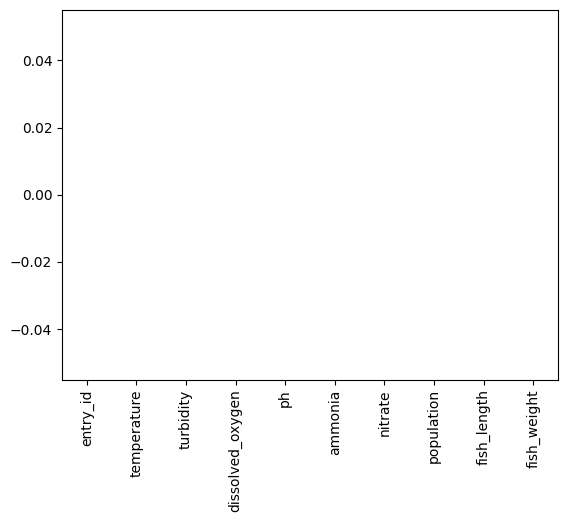

In [10]:
pond1.isna().sum().plot.bar()

In [11]:
pond1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   entry_id          83126 non-null  int64  
 1   temperature       83126 non-null  float64
 2   turbidity         83126 non-null  int64  
 3   dissolved_oxygen  83126 non-null  float64
 4   ph                83126 non-null  float64
 5   ammonia           83126 non-null  float64
 6   nitrate           83126 non-null  int64  
 7   population        83126 non-null  int64  
 8   fish_length       83126 non-null  float64
 9   fish_weight       83126 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.0 MB


In [12]:
pond1.head()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
datetime,,,,,,,,,,
2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


# Exploratory Data Analysis (EDA)

In [13]:
pond1.describe()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
count,83126.000000,83126.000000,83126.000000,83126.000000,83126.000000,8.312600e+04,83126.000000,83126.0,83126.000000,83126.000000
mean,84018.144516,24.573376,87.490160,12.390251,7.518329,2.030817e+08,458.294408,50.0,16.414686,44.568470
std,53579.484245,0.861532,25.859375,12.518253,0.534787,7.863770e+09,338.313206,0.0,5.272180,33.215091
min,1889.000000,-127.000000,1.000000,0.007000,-0.586270,6.770000e-03,45.000000,50.0,7.110000,2.910000
25%,24902.250000,24.125000,91.000000,3.440000,7.153520,4.584200e-01,146.000000,50.0,11.790000,14.190000
50%,103478.500000,24.562500,100.000000,7.133000,7.357790,6.139700e-01,347.000000,50.0,18.080000,54.700000
75%,131074.750000,24.937500,100.000000,15.819000,7.838980,1.565161e+01,823.000000,50.0,21.000000,67.520000
max,247405.000000,27.750000,100.000000,41.046000,8.551670,4.270000e+11,1936.000000,50.0,33.450000,318.640000


### Define variables

In [14]:
# define the variables
# without population since its a contant value
vars = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight','nitrate']

### Histograms and Readings

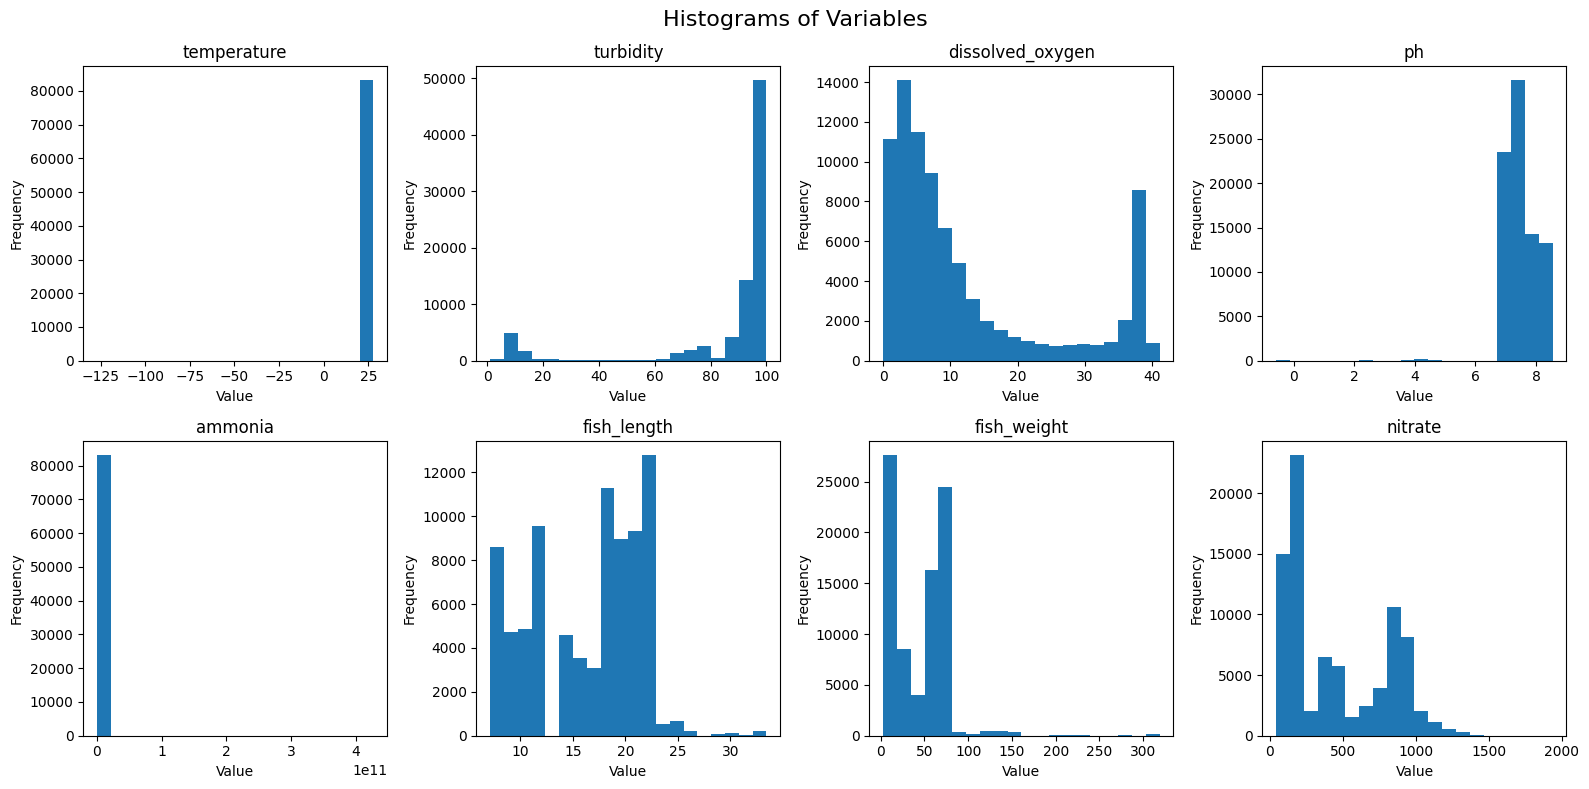

In [15]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1[col], bins=20)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

In [16]:

# Assuming df is your DataFrame
Q1 = pond1.quantile(0.25)
Q3 = pond1.quantile(0.75)
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
pond1_filtered = pond1[~((pond1 < lower_bound) | (pond1 > upper_bound)).any(axis=1)]


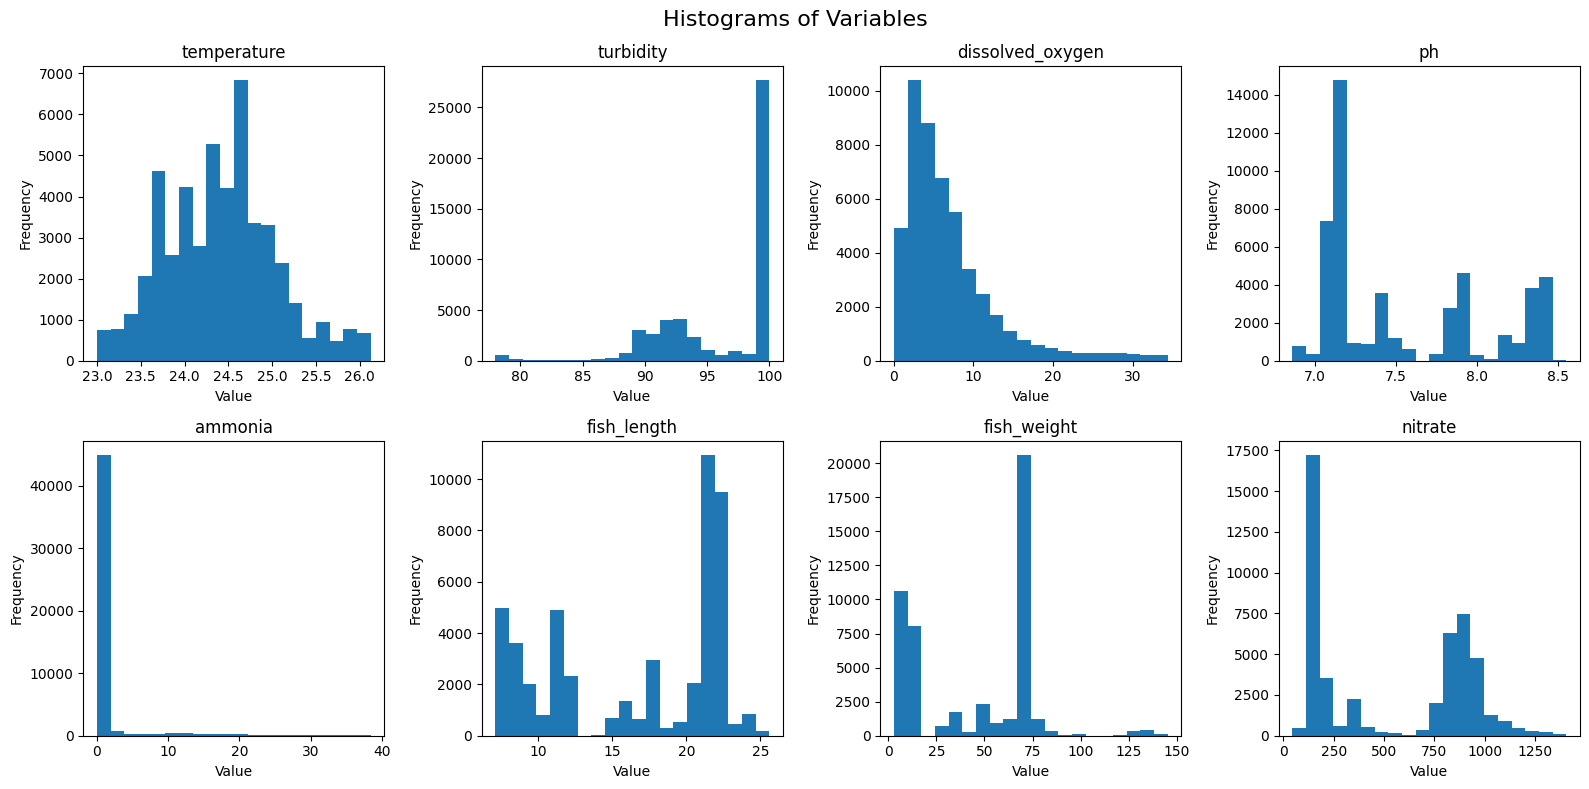

In [17]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1_filtered[col], bins=20)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

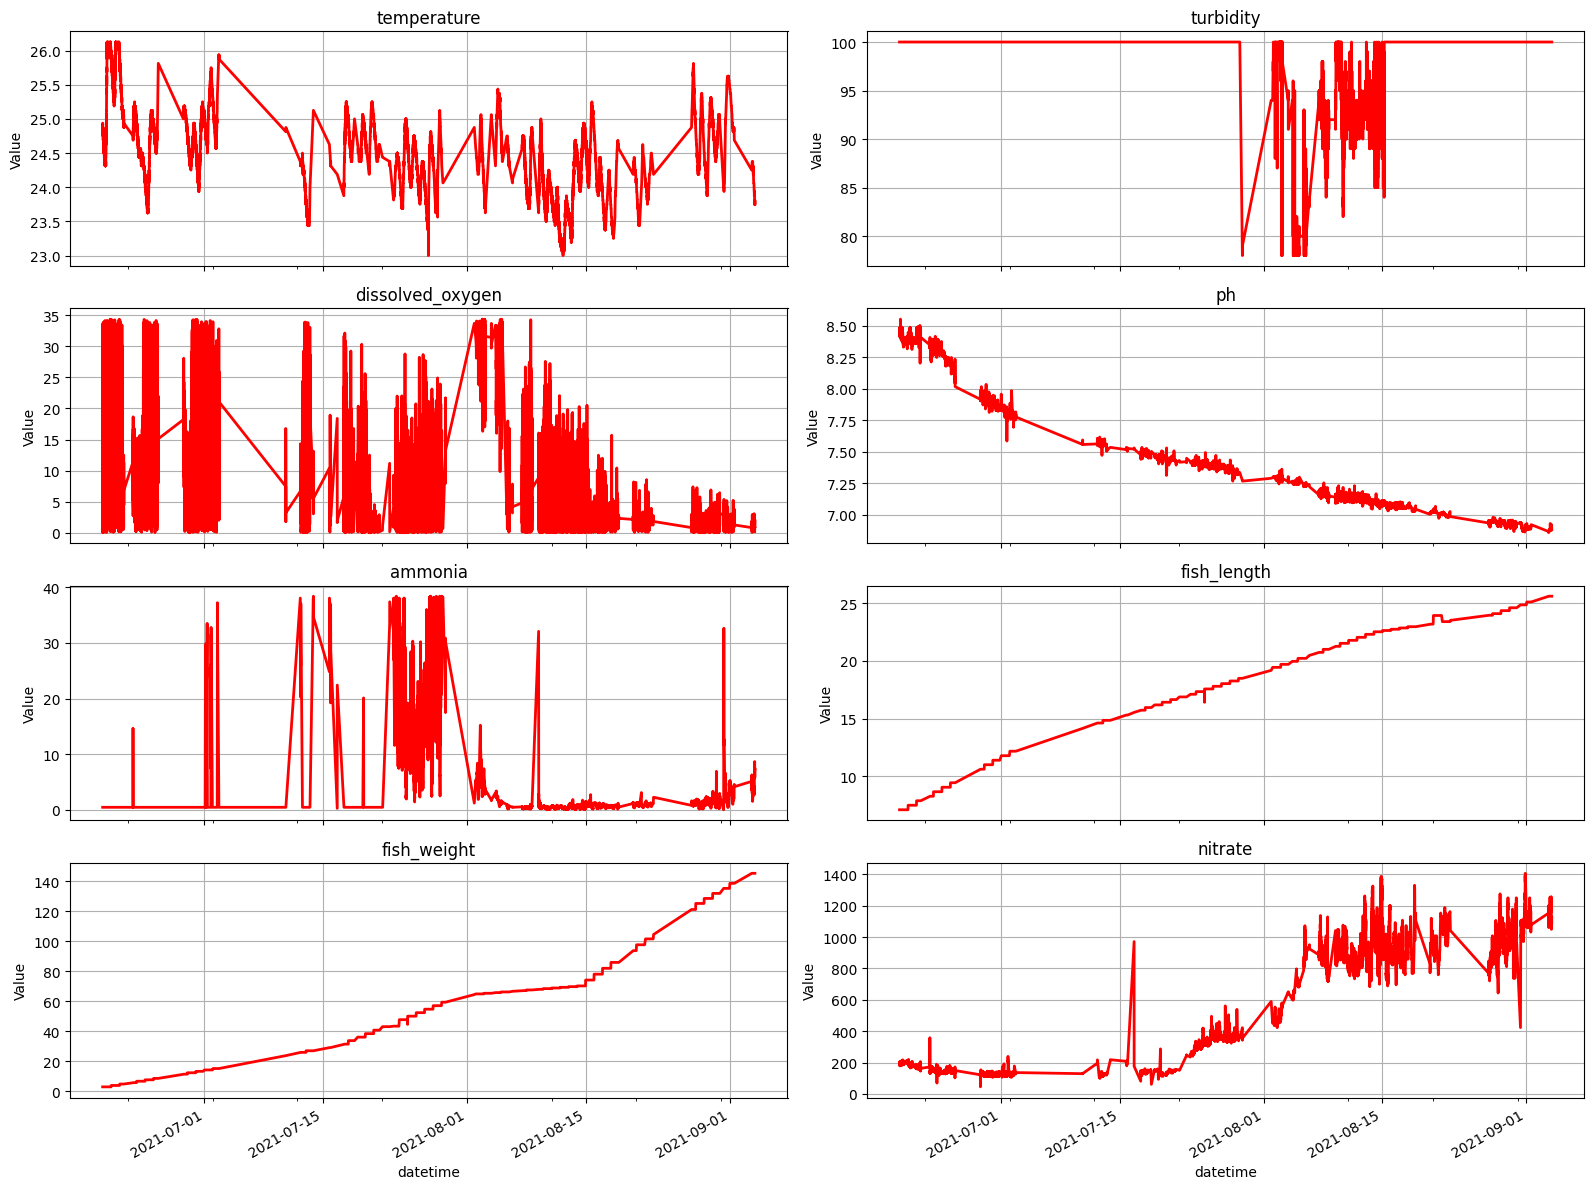

In [18]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables 
for i, col in enumerate(vars):
    pond1_filtered[col].plot(ax=axes[i], title=col, linewidth=2, color='red')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

### Monthly Average

In [19]:
# group by 'datetime' with monthly frequency
pond1_monthly_avg = pond1_filtered.groupby(pd.Grouper(freq='M'))[vars].mean()
pond1_monthly_avg.head()

/var/folders/65/vkw7fp891gz53dgtj8svj4n80000gn/T/ipykernel_32920/3783489280.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pond1_monthly_avg = pond1_filtered.groupby(pd.Grouper(freq='M'))[vars].mean()


,temperature,turbidity,dissolved_oxygen,ph,ammonia,fish_length,fish_weight,nitrate
datetime,,,,,,,,
2021-06-30,24.843595,100.000000,9.125595,8.189350,0.459288,9.168139,7.870642,150.915674
2021-07-31,24.555180,99.977350,6.937771,7.533869,6.974060,15.476101,35.233824,221.246366
2021-08-31,24.045572,92.769124,5.487417,7.121190,0.630877,21.817264,71.492261,898.746946
2021-09-30,24.536325,100.000000,1.423274,6.889454,4.013896,25.377778,142.322222,1141.931624


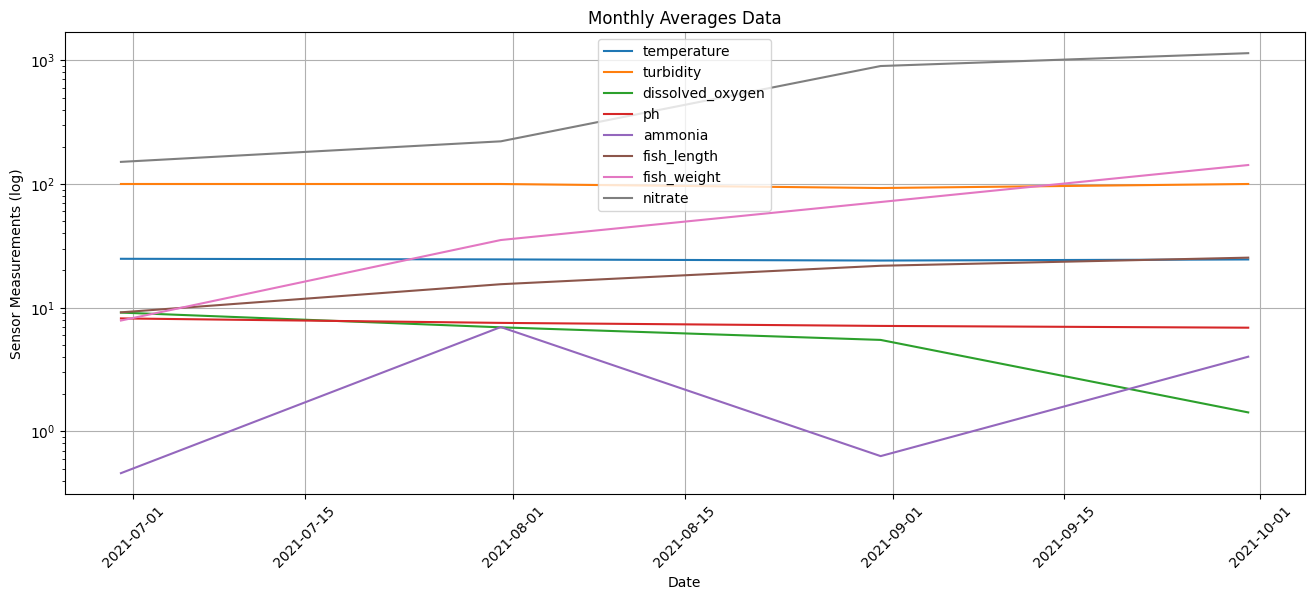

In [20]:
# plot each variable
plt.figure(figsize=(16, 6))
for column in vars:
    plt.plot(pond1_monthly_avg.index,  # months
             pond1_monthly_avg[column],  # monthly average
             label=column)

plt.title('Monthly Averages Data')
plt.xlabel('Date')
plt.ylabel('Sensor Measurements (log)')
plt.yscale('log')  # log scale for readability
plt.legend()
plt.xticks(rotation=45)  # for better visibility
plt.grid(True)
plt.show()

### Data Correlation

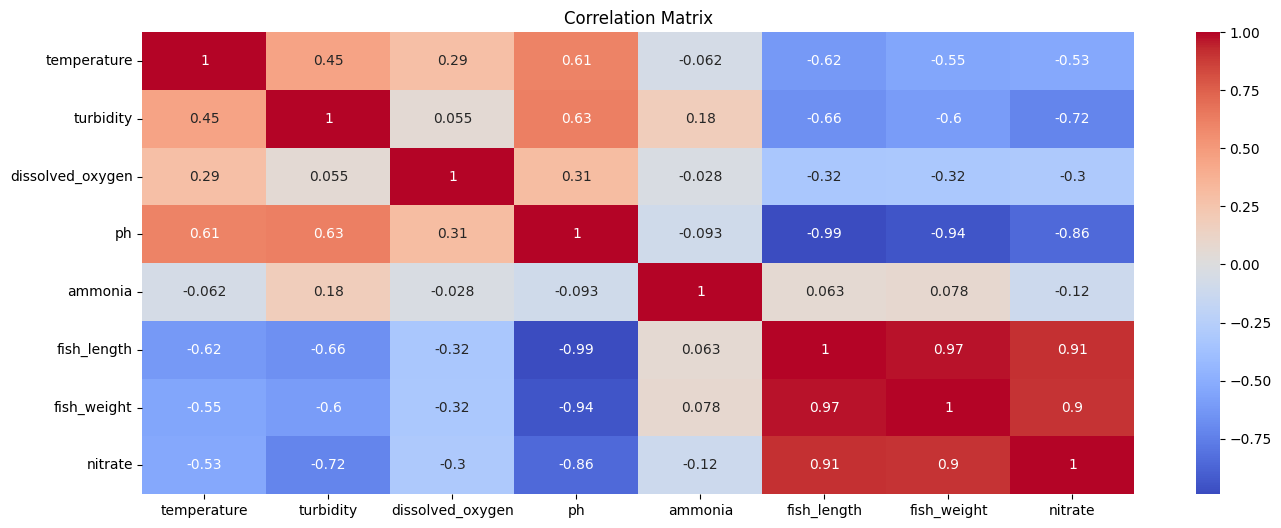

In [21]:
# compute correlation matrix
corr_matrix = pond1_filtered[vars].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Feature Selection

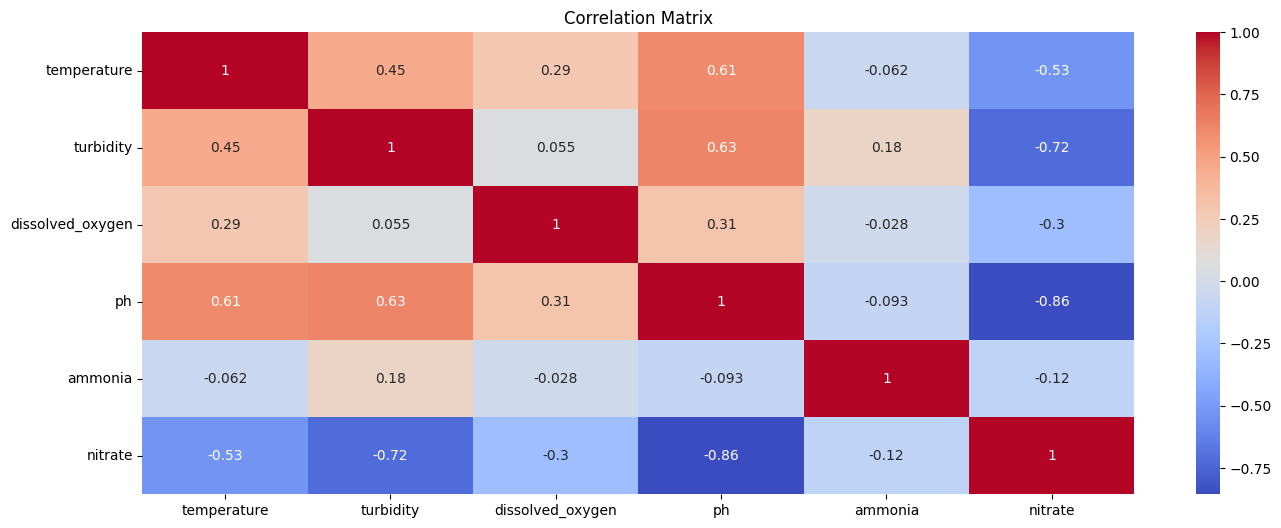

In [22]:
features_for_prediction = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia','nitrate']
corr_matrix = pond1_filtered[features_for_prediction].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

            PC1       PC2
0     -3.232604 -0.038523
1     -3.316313 -0.178703
2     -3.511700 -0.719941
3     -3.274436 -0.083554
4     -3.233653 -0.009918
...         ...       ...
49139  3.839575  1.870993
49140  3.853424  1.694674
49141  3.771126  1.864843
49142  3.788396  1.998276
49143  3.818100  1.981413

[49144 rows x 2 columns]
Explained Variance Ratio: [0.64483957 0.12751743]


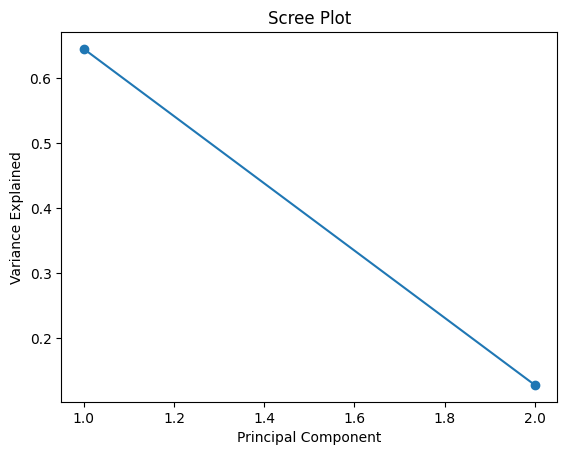

In [23]:
scaler = StandardScaler()
pond_scaled = scaler.fit_transform(pond1_filtered)

# 2. Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
principal_components = pca.fit_transform(pond_scaled)

# 3. Convert to DataFrame
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
print(df_pca)

# 4. Explained Variance Ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# 5. Scree Plot (to decide optimal components)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

#### Feature Selection 
* There are 8 features in the original data set
* For predicting Fish Length,  Correlation Matrix shows  Fish Weight, Ammonia, Nitrate, Temperature and PH has strong correlations with  Fish length.  Since Fish Weight is the observed variable, we can ignore . 
* For time series, prediction we can use Fish length/Fish Weight but these are not IOT data . We can control nitrate value and  predict it for the future

# Machine Learning Models

In [54]:
predicted_feature='ph'

## Traditional

In [55]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] > 0.05:
        print("Series is NOT stationary.")
    else:
        print("Series is stationary.")

adf_test(pond1_filtered[predicted_feature])


pond1_filtered[f'{predicted_feature}_Diff'] = pond1_filtered[predicted_feature].diff()

pond1_filtered[f'{predicted_feature}_Diff'].dropna(inplace=True)


# auto_arima(pond1_filtered[predicted_feature], seasonal=False, trace=True)

ADF Statistic: -1.3643
p-value: 0.5993
Series is NOT stationary.


/var/folders/65/vkw7fp891gz53dgtj8svj4n80000gn/T/ipykernel_32920/3402864773.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pond1_filtered[f'{predicted_feature}_Diff'] = pond1_filtered[predicted_feature].diff()
/var/folders/65/vkw7fp891gz53dgtj8svj4n80000gn/T/ipykernel_32920/3402864773.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pond1_filtered[f'{predicted_feature}_Diff'].dropna(inplace=True)


In [56]:
diff_series=pond1_filtered[f'{predicted_feature}_Diff'].dropna()
adf_test(diff_series)

ADF Statistic: -59.2168
p-value: 0.0000
Series is stationary.


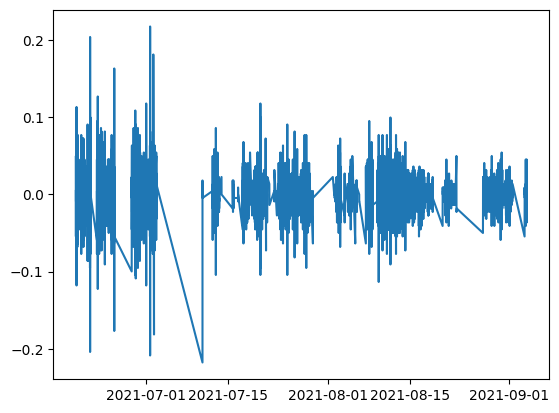

In [57]:
plt.plot(pond1_filtered[f'{predicted_feature}_Diff'])

In [48]:

train_size = int(len(diff_series) * 0.8)
train, test = diff_series.iloc[:train_size], diff_series.iloc[train_size:]

print(f"Train Size: {len(train)}, Test Size: {len(test)}")


Train Size: 39314, Test Size: 9829


In [49]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2, 1, 2))  # Example order (p,d,q)
model_fit = model.fit()
print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

                               SARIMAX Results                                
Dep. Variable:       fish_length_Diff   No. Observations:                39314
Model:                 ARIMA(2, 1, 2)   Log Likelihood              104444.498
Date:                Sun, 16 Feb 2025   AIC                        -208878.996
Time:                        10:45:54   BIC                        -208836.100
Sample:                             0   HQIC                       -208865.407
                              - 39314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8851      0.006   -153.055      0.000      -0.896      -0.874
ar.L2          0.0105      0.002      6.175      0.000       0.007       0.014
ma.L1         -0.0732      0.005    -13.350      0.0

In [52]:
test.values

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# 5. Forecast Future Values
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# 6. Plot Original Data and Forecast
plt.figure(figsize=(10,5))
plt.plot(diff_series.index, pond1_filtered['predicted_feature'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')
plt.legend()
plt.show()

## Deep Learning

# Model Evaluation

# Model Deployment

# Data Export


----------------
$^{1}$ Ogbuokiri, B. (2021). Sensor-based aquaponics fish pond datasets. Kaggle. https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets